# bizwiz value score

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import nltk
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [4]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
df_in=pd.read_parquet('data/bizbuysell.dataset.3.parquet')

In [6]:
df_in.shape

(27338, 34)

In [7]:
df_in.columns

Index(['id', 'src', 'url', 'title', 'desc', 'local', 'region', 'location',
       'title_loc', 'categories', 'similar', 'details', 'financials', 'price',
       'FEATURE_ID', 'FEATURE_NAME', 'FEATURE_CLASS', 'CENSUS_CODE',
       'CENSUS_CLASS_CODE', 'GSA_CODE', 'OPM_CODE', 'STATE_NUMERIC',
       'STATE_ALPHA', 'COUNTY_SEQUENCE', 'COUNTY_NUMERIC', 'COUNTY_NAME',
       'PRIMARY_LATITUDE', 'PRIMARY_LONGITUDE', 'DATE_CREATED', 'DATE_EDITED',
       'STATE_NAME', 'POVERTY_PERCENT', 'MEDIAN_HOUSEHOLD_INCOME', 'H3_15'],
      dtype='object')

In [8]:
dfa=df_in

### text preprocessing

In [9]:
def preprocess_text(text):
    text = text.lower()
    
    text_p = "".join([char for char in text if char not in string.punctuation])
    
    words = word_tokenize(text_p)
    
    stop_words = stopwords.words('english')
    stop_words.append('bizbuysell')
    filtered_words = [word for word in words if word not in stop_words]
    
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in filtered_words]
    
    return " ".join(stemmed)

In [10]:
dfa['pptitle']=dfa['title'].apply(preprocess_text)

In [11]:
dfa['ppdesc']=dfa['desc'].apply(preprocess_text)

### scoring

In [12]:
dfa['global_price_value']=1.0-dfa['price']/dfa.price.max()

In [13]:
dfa['local_price_max']=dfa.groupby(['COUNTY_NUMERIC','STATE_NUMERIC'])['price'].transform('max')
dfa['local_price_value']=1.0-dfa['price']/dfa.local_price_max

In [14]:
dfa['poverty_value']=1.0-(dfa.POVERTY_PERCENT/100.0)

In [15]:
dfa['income_value']=dfa.MEDIAN_HOUSEHOLD_INCOME/dfa.MEDIAN_HOUSEHOLD_INCOME.max()

In [16]:
weights=[1.0,2.0,1.0,1.5]
dfa['bizwiz_value_score']= weights[0]*dfa.global_price_value+ weights[1]*dfa.local_price_value+ \
    weights[2]*dfa.poverty_value+ weights[3]*dfa.income_value

In [17]:
score=dfa["bizwiz_value_score"]

<AxesSubplot:xlabel='bizwiz_value_score', ylabel='Density'>

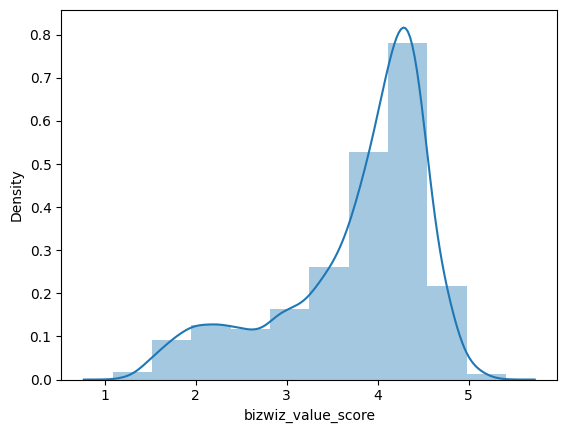

In [18]:
sns.distplot(score, bins=10)

In [19]:
q=score.quantile([0.25, 0.5, 0.75])
def set_class(x):
    if x > q.iloc[2]:
        return 4
    elif x > q.iloc[1]:
        return 3    
    elif x > q.iloc[0]:
        return 2
    return 1
dfa['bizwiz_class']=dfa["bizwiz_value_score"].apply(set_class)

In [20]:
dfa['bizwiz_class'].value_counts()

1    6836
3    6835
2    6834
4    6833
Name: bizwiz_class, dtype: int64

In [21]:
def set_label(x):
    lbl=['','low','medium','high','highest']
    return lbl[x]
dfa['bizwiz_label']=dfa["bizwiz_class"].apply(set_label)

In [22]:
def two_label_num(x):
    if x in (3,4):
        return 2
    return 1
def two_label(x):
    if x in (3,4):
        return 'high'
    return 'low'
dfa['label_num']=dfa["bizwiz_class"].apply(two_label_num)
dfa['label']=dfa["bizwiz_class"].apply(two_label)

In [23]:
df_out=dfa[['id','pptitle','ppdesc','COUNTY_NAME','STATE_NAME',
            'bizwiz_value_score','bizwiz_class','bizwiz_label','label_num','label']]

In [24]:
df_out=df_out.dropna()

In [25]:
df_out.columns

Index(['id', 'pptitle', 'ppdesc', 'COUNTY_NAME', 'STATE_NAME',
       'bizwiz_value_score', 'bizwiz_class', 'bizwiz_label', 'label_num',
       'label'],
      dtype='object')

In [26]:
df_out.shape

(27336, 10)

In [27]:
df_out.head()

,id,pptitle,ppdesc,COUNTY_NAME,STATE_NAME,bizwiz_value_score,bizwiz_class,bizwiz_label,label_num,label
1,1990890.0,high exposur may land new jersey,amaz opportun price sell readi busi locat hear...,Atlantic,New Jersey,4.062859,3,high,2,high
3,2039720.0,duplex short term long term pinella counti flo...,rare largoseminol area duplex central locat pi...,Pinellas,Florida,3.464210,2,medium,1,low
4,1576680.0,major price reduct resttavern 13000sq ft build...,price reduc 850 000 make offercurr owner want ...,Baltimore (city),Maryland,2.505054,1,low,1,low
5,2087638.0,busi real estat casco michigan,• busi real estat sale• liquorshopp first floo...,St. Clair,Michigan,2.973314,1,low,1,low
7,2051958.0,turnkey restaur near lake wister state park hi...,commerci real estat sale welcom 409 us highway...,Le Flore,Oklahoma,3.712142,2,medium,1,low


In [28]:
df_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27336 entries, 1 to 208608
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  27336 non-null  float64
 1   pptitle             27336 non-null  object 
 2   ppdesc              27336 non-null  object 
 3   COUNTY_NAME         27336 non-null  object 
 4   STATE_NAME          27336 non-null  object 
 5   bizwiz_value_score  27336 non-null  float64
 6   bizwiz_class        27336 non-null  int64  
 7   bizwiz_label        27336 non-null  object 
 8   label_num           27336 non-null  int64  
 9   label               27336 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 2.3+ MB


In [29]:
df_out.to_parquet('data/bizwiz_value_score.parquet')